# Import Libraries

In [ ]:
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pathlib
import random
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [168]:
path = 'C:\\Users\\Lenvo\\Desktop\\Pneumonia'
data_dir = pathlib.Path(path)


In [169]:
# List all files in the directory
Files = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(Files)


['Normal' 'Pneumonia' 'test']


In [170]:
# Join paths for 'Pneumonia' and 'Normal' directories using pathlib
pneumoniaPath = data_dir / 'Pneumonia'
normalPath = data_dir / 'Normal'


In [171]:
# Count the number of images in each directory
imageCountPneumonia = len(list(pneumoniaPath.glob('*.jpeg')))
imageCountNormal = len(list(normalPath.glob('*.jpeg')))

# Print the counts
print("Number of Pneumonia images:", imageCountPneumonia)
print("Number of Normal images:", imageCountNormal)


Number of Pneumonia images: 1023
Number of Normal images: 612


# Datasets Preprocessing

In [172]:
# Constants
img_height = 100
img_width = 100
batch_size = 32

In [173]:
# Enhancing images
def preprocess(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)
    return img


In [174]:
# Load, preprocess, and resize images
def load_preprocess_resize(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = preprocess(img)
    img = cv2.resize(img, (img_width, img_height))
    img1 = image.load_img(filepath, target_size=(img_height, img_width))
    img1 = image.img_to_array(img1)
    return img

In [175]:
# Load and preprocess images in batches
def load_and_preprocess_batch(filepaths):
    return [load_preprocess_resize(str(img_path)) for img_path in filepaths]

In [176]:
# Load and preprocess images for each class
pneumonia_images = load_and_preprocess_batch(list(data_dir.glob('Pneumonia/*.jpeg')))
normal_images = load_and_preprocess_batch(list(data_dir.glob('Normal/*.jpeg')))

In [177]:
# Convert images to NumPy array
pneumonia_images = np.array(pneumonia_images, dtype=np.float32)

normal_images = np.array(normal_images, dtype=np.float32)


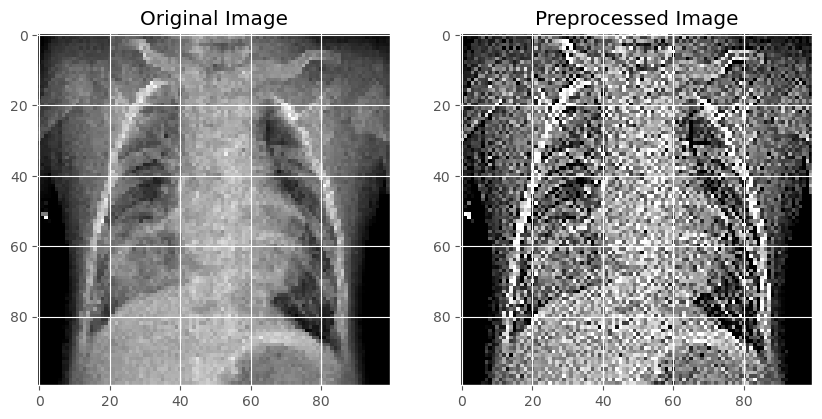

In [178]:
# Testing with an example image
testing = 'C:\\Users\\Lenvo\Desktop\\Pneumonia\\Pneumonia\\pneumoniaa.jpeg'
img1 = load_preprocess_resize(testing)
# Show the original and preprocessed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Original Image')

img1_processed = preprocess(img1)

plt.subplot(1, 2, 2)
plt.imshow(img1_processed)
plt.title('Preprocessed Image')

plt.show()

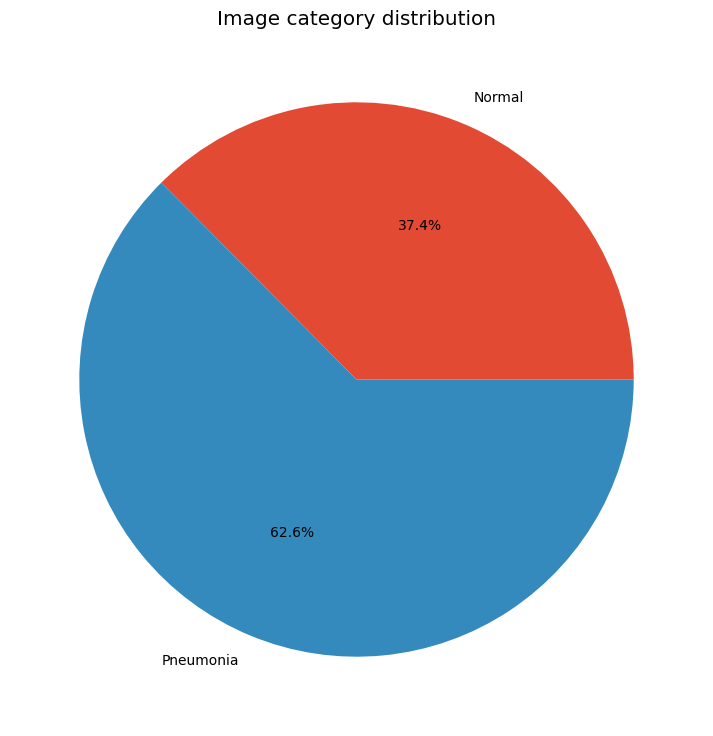

In [159]:
# Labelling the output
labels = ['Normal', 'Pneumonia']

# Getting the sum of each outcome
targets = [len(normal_images), len(pneumonia_images)]

# Plotting the pie chart
plt.style.use('ggplot')
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image category distribution")
plt.show()

In [201]:
# Checking image formats

from pathlib import Path
import imghdr

data_dir = 'C:\\Users\\Lenvo\Desktop\\Pneumonia'
image_extensions = [".png", ".jpg"]  

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

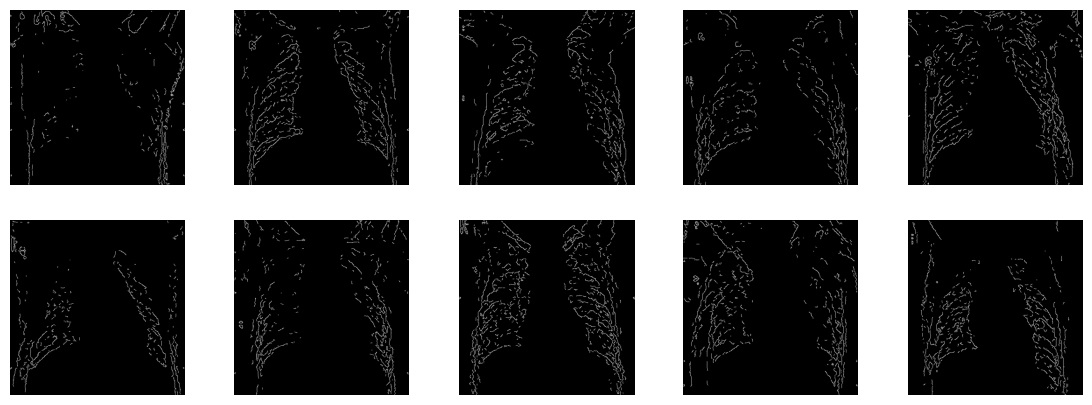

In [179]:
# Creating empty lists to store images
all_pneumonia = pneumonia_images  # Replace with your actual list
all_normal = normal_images  # Replace with your actual list

# Setting the figsize
fig = plt.figure(figsize=(14, 5))

# Setting up the frame for subplots
columns = 5
rows = 2

# Combining the datasets
img_dataset = all_pneumonia[:50] + all_normal[:50]

# Plotting the images
for i, img in enumerate(img_dataset, 1):
    img = cv2.resize(img, (512, 512))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Ensure the image is of data type CV_8U
    img_gray = cv2.convertScaleAbs(img_gray)

    edges = cv2.Canny(img_gray, 80, 100)

    # Adding subplots to the figure
    if i <= rows * columns:
        fig.add_subplot(rows, columns, i)

        # Displaying images with edges using a grayscale colormap
        plt.imshow(edges, cmap='gray')
        plt.axis(False)

# Show the entire figure
plt.show()


# Data splitting

In [181]:
# Data Splitting
path = 'C:\\Users\\Lenvo\Desktop\\Pneumonia'
data_dir = pathlib.Path(path)

pneumoniaPath = data_dir / 'Pneumonia'
normalPath = data_dir / 'Normal'

In [182]:
# Data Splitting
train_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)



Found 1653 files belonging to 3 classes.
Using 1323 files for training.
Found 1653 files belonging to 3 classes.
Using 330 files for validation.


# Define the model

In [183]:
# Define the model with hyperparameter tuning
def build_model(learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(dropout_rate),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(Files), activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Hyperparameter tuning

In [184]:

# Hyperparameter tuning
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'dropout_rate': [0.3, 0.5, 0.7]}
param_combinations = list(ParameterGrid(param_grid))

# Using same data split for hyperparameter tuning
train_data_for_tuning = image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size
)

val_data_for_tuning = image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size
)



Found 1653 files belonging to 3 classes.
Using 1323 files for training.
Found 1653 files belonging to 3 classes.
Using 330 files for validation.


In [187]:

# Hyperparameter tuning
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'dropout_rate': [0.3, 0.5, 0.7]}
param_combinations = list(ParameterGrid(param_grid))

best_accuracy = 0.0
best_model = None

for params in param_combinations:
    model = build_model(learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'])
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    _, accuracy = model.evaluate(val_data)
    print(f'Learning Rate: {params["learning_rate"]}, Dropout Rate: {params["dropout_rate"]}, Accuracy: {accuracy}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model



Epoch 1/10
42/42 [==============================] - 21s 377ms/step - loss: 391.7834 - accuracy: 0.5699 - val_loss: 17519.1152 - val_accuracy: 0.3939
Epoch 2/10
42/42 [==============================] - 17s 381ms/step - loss: 0.7168 - accuracy: 0.6259 - val_loss: 1866.5289 - val_accuracy: 0.3939
Epoch 3/10
42/42 [==============================] - 18s 395ms/step - loss: 0.7129 - accuracy: 0.6243 - val_loss: 245.6244 - val_accuracy: 0.4636
Epoch 4/10
42/42 [==============================] - 17s 386ms/step - loss: 0.7119 - accuracy: 0.6251 - val_loss: 37.0270 - val_accuracy: 0.5364
Epoch 5/10
42/42 [==============================] - 17s 377ms/step - loss: 0.7123 - accuracy: 0.6251 - val_loss: 3.7114 - val_accuracy: 0.5667
Epoch 6/10
42/42 [==============================] - 19s 403ms/step - loss: 0.7132 - accuracy: 0.6251 - val_loss: 0.8754 - val_accuracy: 0.5909
Epoch 7/10
42/42 [==============================] - 17s 367ms/step - loss: 0.7152 - accuracy: 0.6251 - val_loss: 0.7315 - val_accu

42/42 [==============================] - 17s 376ms/step - loss: 0.1364 - accuracy: 0.9516 - val_loss: 0.5306 - val_accuracy: 0.8273
Epoch 4/10
42/42 [==============================] - 17s 374ms/step - loss: 0.1033 - accuracy: 0.9667 - val_loss: 0.3587 - val_accuracy: 0.8939
Epoch 5/10
42/42 [==============================] - 18s 408ms/step - loss: 0.1193 - accuracy: 0.9577 - val_loss: 0.2942 - val_accuracy: 0.9061
Epoch 6/10
42/42 [==============================] - 16s 350ms/step - loss: 0.0861 - accuracy: 0.9713 - val_loss: 0.1938 - val_accuracy: 0.9515
Epoch 7/10
42/42 [==============================] - 19s 417ms/step - loss: 0.0568 - accuracy: 0.9773 - val_loss: 0.1210 - val_accuracy: 0.9636
Epoch 8/10
42/42 [==============================] - 18s 409ms/step - loss: 0.0298 - accuracy: 0.9894 - val_loss: 0.1440 - val_accuracy: 0.9576
Epoch 9/10
42/42 [==============================] - 17s 370ms/step - loss: 0.0284 - accuracy: 0.9879 - val_loss: 0.1494 - val_accuracy: 0.9667
Epoch 10/1

In [188]:
# Evaluate the best model on validation data
_, accuracy = best_model.evaluate(val_data)
print(f'Highest Model - Accuracy: {accuracy}')

# Display the best model summary
best_model.summary()

# Save the best model
best_model.save('model.h5')
print('Highest Accuracy Model Saved Successfully!')

11/11 [==============================] - 2s 66ms/step - loss: 0.2669 - accuracy: 0.9424
Highest Model - Accuracy: 0.9424242377281189
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_123 (B  (None, 100, 100, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_123 (MaxPool  (None, 50, 50, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_124 (Conv2D)         (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_124 (B  (None, 50, 50, 64)     

# Confusion Matrix

1/1 [==============================] - 0s 90ms/step


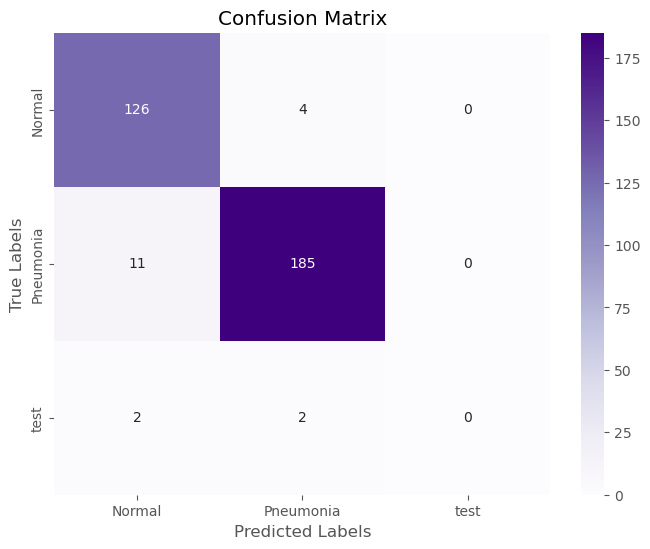

In [200]:
# Generate predictions for confusion matrix
# Generate predictions for confusion matrix
y_true = []
y_pred = []

for images, labels in val_data:
    predictions = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=Files, yticklabels=Files)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report

In [202]:
# Classification Report
print("Classification Report:")
classification_rep = classification_report(y_true, y_pred, target_names=Files, output_dict=True)

# Print header
print(f"\n{'Class': <15}{'Precision': <20}{'Recall': <20}{'F1-Score': <20}{'Support': <15}")
print("-" * 100)

# Print metrics for each class
for class_name, metrics in classification_rep.items():
    if class_name == 'accuracy':
        continue  # Skip printing accuracy separately
    print(f"{class_name: <15}   {metrics['precision']:.4f}           {metrics['recall']:.4f}             {metrics['f1-score']:.4f}              {metrics['support']:<15}")

# Overall Accuracy
accuracy = classification_rep['accuracy']
print("\nOverall Accuracy:")
print(f"Accuracy: {accuracy:.4f}")


Classification Report:

Class          Precision           Recall              F1-Score            Support        
----------------------------------------------------------------------------------------------------
Normal            0.9065           0.9692             0.9368              130            
Pneumonia         0.9686           0.9439             0.9561              196            
test              0.0000           0.0000             0.0000              4              
macro avg         0.6250           0.6377             0.6310              330            
weighted avg      0.9324           0.9424             0.9369              330            

Overall Accuracy:
Accuracy: 0.9424


# Accuracy and Loss scores

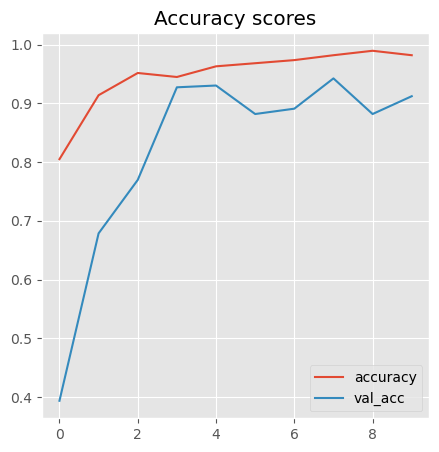

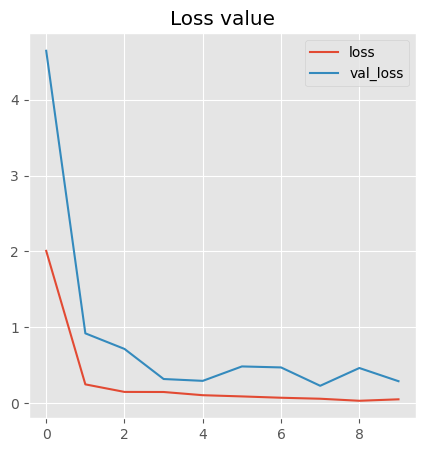

In [191]:
#Setting up image size
plt.figure(figsize=(5, 5))

#Plot train and validation accuracy
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_acc'])
plt.show()

#Plot train and validation loss
plt.figure(figsize=(5,5))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

# Model Evaluation

In [192]:
# Evaluating
model.evaluate(val_data)

11/11 [==============================] - 2s 69ms/step - loss: 0.2883 - accuracy: 0.9121


[0.2883155047893524, 0.9121212363243103]

# Raw Predictions

In [194]:
# Make predictions
predictions = model.predict(test_image)

# Print raw predictions
print("Raw Predictions:", predictions)

# Get the class index with the highest probability
predicted_class_index = np.argmax(predictions)

# Map the index to the corresponding class name
predicted_class = Files[predicted_class_index]

# Get true class name from the file path
true_class = test_image_path.split('\\')[-2]

# Check if the prediction is correct
correct_prediction = predicted_class == true_class

# Display the result
print(f'True Class: {true_class}')
print(f'Predicted Class: {predicted_class}')


1/1 [==============================] - 0s 66ms/step
Raw Predictions: [[2.0091396e-04 2.0239441e-02 9.7955954e-01]]
True Class: test
Predicted Class: test


# Pneumonia Test with Random image

1/1 [==============================] - 0s 288ms/step
True Class: test
Predicted Class: test
No Pneumonia Detected.


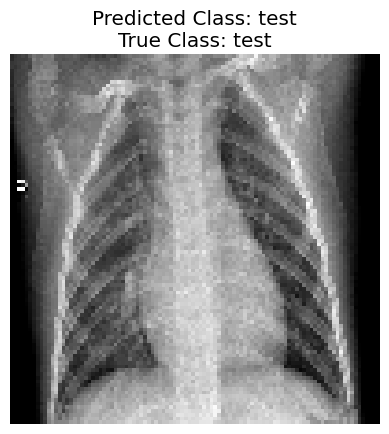

In [198]:
#saved model
model = models.load_model('model.h5')

def load_and_preprocess_single_image(filepath):
    img = load_preprocess_resize(filepath)
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    return img_array, img

test_image_path = 'C:\\Users\\Lenvo\\Desktop\\Pneumonia\\test\\tests (1).jpeg'
test_image, original_image = load_and_preprocess_single_image(test_image_path)

# Make predictions
predictions = model.predict(test_image)

# Get the class index with the highest probability
predicted_class_index = np.argmax(predictions)

# Map the index to the corresponding class name
predicted_class = Files[predicted_class_index]

# Get true class name from the file path
true_class = test_image_path.split('\\')[-2]

# Check if the prediction is correct
correct_prediction = predicted_class == true_class

# Display the result
print(f'True Class: {true_class}')
print(f'Predicted Class: {predicted_class}')

# Check if the prediction is correct
if predicted_class == 'Pneumonia':
    print('Pneumonia Detected!')
else:
    print('No Pneumonia Detected.')

# Display the image and prediction
plt.imshow(original_image)
plt.title(f'Predicted Class: {predicted_class}\nTrue Class: {true_class}')
plt.axis('off')
plt.show()
